In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [30]:
class StockPredictionModel:
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model = None

    def load_data(self):
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        df.astype(float)

        x = df.drop(["Adj Close", "Close"], axis=1)
        y = df["Adj Close"].values.reshape(-1, 1)

        self.x_scaler = MinMaxScaler(feature_range=(0, 1))
        self.y_scaler = MinMaxScaler(feature_range=(0, 1))

        self.x_transformed = self.x_scaler.fit_transform(x)
        self.y_transformed = self.y_scaler.fit_transform(y)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
            self.x_transformed, self.y_transformed, test_size=0.2, random_state=42
            )

        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], 1, self.x_train.shape[1]))
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], 1, self.x_test.shape[1]))

        return df  # Ensure the DataFrame is returned

    def build_model(self):
        self.model = Sequential([
            GRU(units=100, return_sequences=True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])),
            Dropout(rate=0.3),

            GRU(units=100, return_sequences=True),
            Dropout(rate=0.3),

            GRU(units=50, return_sequences=True),
            Dropout(rate=0.3),

            GRU(units=50),
            Dropout(rate=0.3),
            Dense(units=1)
        ])

        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.summary()

    def train_model(self, epochs=30, batch_size=24):
        self.history = self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self):
        self.y_pred = self.model.predict(self.x_test)

        self.y_test_original = self.y_scaler.inverse_transform(self.y_test)
        self.y_pred_original = self.y_scaler.inverse_transform(self.y_pred)

        return self.y_test_original, self.y_pred_original

    def back_test(self, test_data, pred_data):
        mse = mean_squared_error(test_data, pred_data)
        mae = mean_absolute_error(test_data, pred_data)
        r2_score_val = r2_score(test_data, pred_data)
        variance = explained_variance_score(test_data, pred_data)

        print("Mean Square Error:", mse)
        print("Mean Absolute Error:", mae)
        print("R2-Score:", r2_score_val)
        print("Explained Variance Score:", variance)

        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(test_data, label='Actual')
        plt.plot(pred_data, label='Predicted')
        plt.title('Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        plt.subplot(2, 1, 2)
        residuals = test_data - pred_data
        plt.plot(residuals, label='Residuals')
        plt.title('Residuals')
        plt.xlabel('Date')
        plt.ylabel('Residual')
        plt.legend()
        plt.tight_layout()
        plt.show()

    

In [31]:
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
def generate_ohlc(data):
    """ Generate synthetic OHLC data from adjusted close prices. """
    ohlc = pd.DataFrame()
    ohlc['Open'] = data['Adj Close']
    ohlc['High'] = data['Adj Close'] + np.random.uniform(0, 0.05, len(data))
    ohlc['Low'] = data['Adj Close'] - np.random.uniform(0, 0.05, len(data))
    ohlc['Close'] = data['Adj Close']
    return ohlc

def convert_predictions_to_ohlc(predictions, dates):
    """ Convert predicted adjusted close prices to OHLC data. """
    pred_df = pd.DataFrame(predictions, index=dates, columns=['Adj Close'])
    ohlc_pred = generate_ohlc(pred_df)
    return ohlc_pred

def plot_candlestick_with_predictions(df_actual, df_pred):
    df_actual = df_actual.loc[:, ['Open', 'High', 'Low', 'Close']]
    df_actual.reset_index(inplace=True)
    df_actual['Date'] = df_actual['Date'].map(mdates.date2num)

    df_pred = df_pred.loc[:, ['Open', 'High', 'Low', 'Close']]
    df_pred.reset_index(inplace=True)
    df_pred['Date'] = df_pred['Date'].map(mdates.date2num)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    candlestick_ohlc(ax, df_actual.values, width=0.6, colorup='g', colordown='r', alpha=0.7)
    candlestick_ohlc(ax, df_pred.values, width=0.2, colorup='blue', colordown='blue', alpha=0.7)
    ax.xaxis_date()
    ax.set_title('Candlestick chart with Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(['Actual', 'Predicted'])
    plt.show()




[*********************100%***********************]  1 of 1 completed
C:\Users\Peanut\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_44 (GRU)                    │ (None, 1, 100)         │        31,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_45 (GRU)                    │ (None, 1, 100)         │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_46 (GRU)                    │ (None, 1, 50)          │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_47 (GRU)                    │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,551 (509.96 KB)

 Trainable params: 130,551 (509.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0580
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021
Epoch 9/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 10/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024
Epoch 11/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 12/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 13/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Epoch 14/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022
Epoch 15/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019
Epoch 16/30
84/84 ━

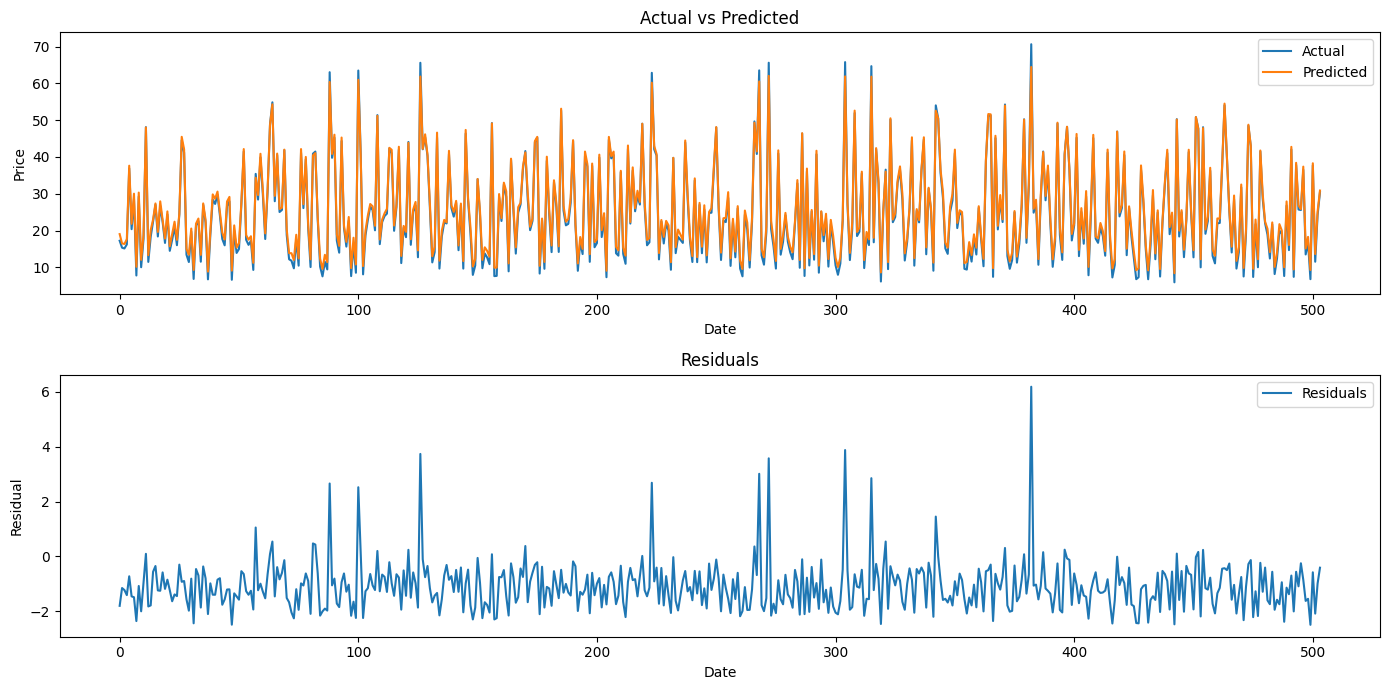

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=True
  • mask=None

In [32]:
if __name__ == "__main__":
    model = StockPredictionModel(ticker="AAPL", start_date="2010-01-01", end_date="2020-01-01")
    df = model.load_data()
    model.build_model()
    model.train_model(epochs=30, batch_size=24)
    y_test_original, y_pred_original = model.predict()
    model.back_test(y_test_original, y_pred_original)

    model.cross_validate() 
    rolling_predictions = model.rolling_window_analysis() 
    walk_forward_predictions = model.walk_forward_validation()

    ohlc_pred = convert_predictions_to_ohlc(y_pred_original, df.index[-len(y_pred_original):])
    plot_candlestick_with_predictions(df, ohlc_pred)





In [25]:
from sklearn.model_selection import TimeSeriesSplit

def time_series_cross_validation(model, X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print("R2 Score:", r2_score(y_test, y_pred))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras import Sequential
import yfinance as yf

class StockPredictionModel:
    # Existing methods...



# Usage Example
if __name__ == "__main__":
    model = StockPredictionModel(ticker="AAPL", start_date="2010-01-01", end_date="2020-01-01")
    df = model.load_data()  # Capture the DataFrame here
    model.build_model()
    model.train_model(epochs=30, batch_size=24)
    y_test_original, y_pred_original = model.predict()
    model.back_test(y_test_original, y_pred_original)

    # Monte Carlo Simulation
    simulations = model.monte_carlo_simulation()
    plot_monte_carlo_simulation(simulations)

    # Hyperparameter Optimization
    param_bounds = {'n_estimators': (50, 200), 'max_depth': (3, 10), 'learning_rate': (0.01, 0.3)}
    best_params = model.optimize_hyperparameters(param_bounds)
    print("Best Parameters:", best_params)

    # Ensemble Learning
    model2 = RandomForestRegressor(n_estimators=100)
    y_pred_ensemble = model.ensemble_learning(model2)
    print("R2 Score of Ensemble Model:", r2_score(model.y_test, y_pred_ensemble))

    # Scenario Analysis
    scenarios = {'Bullish': (model.x_transformed[:, 0] > 0), 'Bearish': (model.x_transformed[:, 0] < 0), 'Sideways':

#https://medium.com/@udaytripurani04/stock-market-predictions-using-lstm-and-gru-models-with-python-ca103183dbc0